In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import spacy
import time
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import gensim


from sklearn.metrics import precision_recall_fscore_support 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


Using TensorFlow backend.


In [2]:
df = pd.read_json('DiSmldata.json')

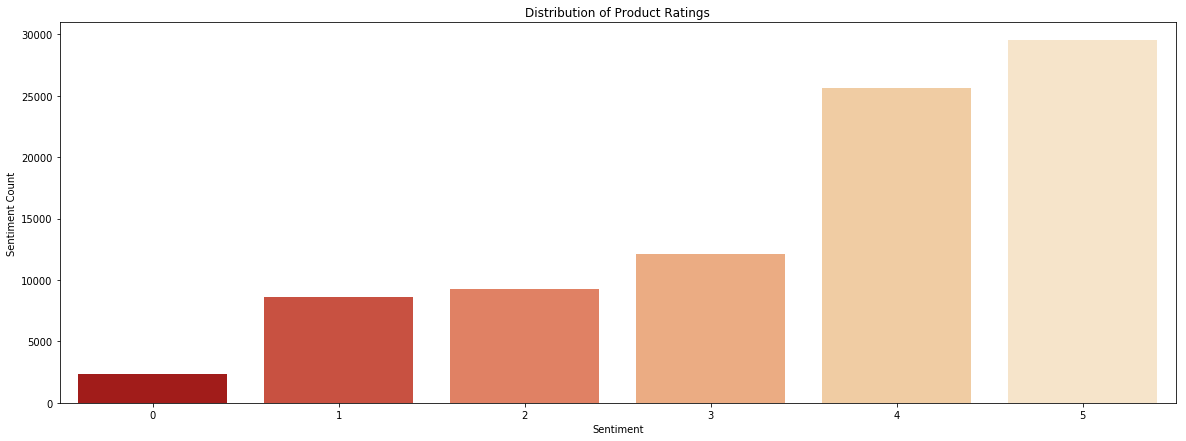

In [3]:
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["label"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Sentiment", ylabel="Sentiment Count")
plt.show()

In [82]:
my_stop_words = ENGLISH_STOP_WORDS.union(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                                         'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                                         'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                                         'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                                         '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                                          "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                                          'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                                          'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                                          '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl'])

In [5]:
#Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(df[['hash_count', 'emoji_count','clean_text',
                                                        'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']], df['label'],test_size =0.20, random_state = 77)

In [40]:
#Count vectorizer Document term matrix
count_vect = CountVectorizer(stop_words = my_stop_words, min_df = 3, max_df = 50)
count_vect_fit = count_vect.fit(X_train['clean_text'])

count_train = count_vect_fit.transform(X_train['clean_text'])
count_test = count_vect_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [41]:
X_train_vect.shape

(70008, 12029)

In [44]:
#Balance the Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [45]:
X_resampled_ros_test, y_resampled_ros_test = ros.fit_resample(X_test_vect.values, y_test.values)
print(sorted(Counter(y_resampled_ros_test).items()))

[(0, 5982), (1, 5982), (2, 5982), (3, 5982), (4, 5982), (5, 5982)]


In [48]:
#Random Forest

#Instantiate our model 
rf = RandomForestClassifier(n_estimators=50, max_depth=1000, n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_resampled_ros_test)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3)))

Fit time: 719.459 / Predict time: 5.263 ---- Precision: 0.528 / Recall: 0.493 / Accuracy: 0.493


In [50]:
#Random Forest tells our Feature Importances
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect.columns), reverse=True))[0:20]

[(0.1355676226213802, 'tweet_len'),
 (0.06981465925893084, 'cap_count'),
 (0.06160885541980688, 'punc_count'),
 (0.04983365735000892, 'hash_count'),
 (0.02588826210923301, 'joy'),
 (0.02482664727491569, 'sadness'),
 (0.022244452728189482, 'emoji_count'),
 (0.019968127916541976, 'fear'),
 (0.018719362934182426, 'anticipation'),
 (0.01675342786142678, 'anger'),
 (0.015328056959726938, 'disgust'),
 (0.01524454533328769, 'trust'),
 (0.011318434836613203, 'surprise'),
 (0.0008697401680626791, 3638),
 (0.0008291998036010272, 6213),
 (0.0008277462158314285, 10826),
 (0.0008061685178150136, 10052),
 (0.0007768196630855878, 2632),
 (0.0007207657655482084, 7524),
 (0.0007068535968719075, 2360)]

In [51]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB()

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_resampled_ros_test)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3)))

Fit time: 596.526 / Predict time: 6.169 ---- Precision: 0.494 / Recall: 0.491 / Accuracy: 0.491


In [52]:
#Logistic Regression 

#Instantiate our model
lr = LogisticRegression(max_iter = 100, solver = 'lbfgs')

#Train our Model
start = time.time()
lr.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = lr.predict(X_resampled_ros_test)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), 
    round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3)))

/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fit time: 861.007 / Predict time: 3.461 ---- Precision: 0.42 / Recall: 0.414 / Accuracy: 0.414


#### TFIDF

In [6]:
#TFIDF vector DTM
tfidf_vect = TfidfVectorizer(stop_words = my_stop_words, min_df = 3, max_df = 50)
tfidf_vect_fit = tfidf_vect.fit(X_train['clean_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['clean_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['clean_text'])

X_train_vect_tf = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect_tf = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

In [55]:
X_train_vect_tf.shape

(70008, 12029)

In [8]:
#Balance the Data 
ros = RandomOverSampler(random_state=77) 
X_resampled_ros_tf, y_resampled_ros_tf = ros.fit_resample(X_train_vect_tf.values, y_train.values)
print(sorted(Counter(y_resampled_ros_tf).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [9]:
X_resampled_ros_test_tf, y_resampled_ros_test_tf = ros.fit_resample(X_test_vect_tf.values, y_test.values)
print(sorted(Counter(y_resampled_ros_test_tf).items()))

[(0, 5982), (1, 5982), (2, 5982), (3, 5982), (4, 5982), (5, 5982)]


In [10]:
#Random Forest

#Instantiate our model 
rf = RandomForestClassifier(n_estimators=50, max_depth=1000, n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros_tf, y_resampled_ros_tf)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_resampled_ros_test_tf)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test_tf, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test_tf).sum()/len(y_pred), 3)))

Fit time: 712.098 / Predict time: 7.252 ---- Precision: 0.526 / Recall: 0.491 / Accuracy: 0.491


In [12]:
#Random Forest tells our Feature Importances
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect_tf.columns), reverse=True))[0:20]

[(0.13348286106624357, 'tweet_len'),
 (0.06675093458904073, 'cap_count'),
 (0.06187580467148789, 'punc_count'),
 (0.0499041330696658, 'hash_count'),
 (0.026270729450527608, 'joy'),
 (0.025620086296029947, 'sadness'),
 (0.021539711901196627, 'emoji_count'),
 (0.02129386218552071, 'fear'),
 (0.018340592860136274, 'anticipation'),
 (0.014659223551072288, 'trust'),
 (0.014280392810640028, 'anger'),
 (0.014154633767097847, 'disgust'),
 (0.010524613610567531, 'surprise'),
 (0.0008712632223012992, 6213),
 (0.0008554590915700229, 10052),
 (0.0008364796935487842, 2360),
 (0.0008124037843868159, 7524),
 (0.0008037226752877644, 2632),
 (0.000754955124494401, 5147),
 (0.0007525454628223672, 3638)]

In [13]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB()

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros_tf, y_resampled_ros_tf)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_resampled_ros_test_tf)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test_tf, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test_tf).sum()/len(y_pred), 3)))

Fit time: 32.631 / Predict time: 3.374 ---- Precision: 0.481 / Recall: 0.48 / Accuracy: 0.48


In [14]:
#Logistic Regression 

#Instantiate our model
lr = LogisticRegression(max_iter = 100, solver = 'lbfgs')

#Train our Model
start = time.time()
lr.fit(X_resampled_ros_tf, y_resampled_ros_tf)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = lr.predict(X_resampled_ros_test_tf)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test_tf, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test_tf).sum()/len(y_pred), 3)))

/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fit time: 916.527 / Predict time: 3.67 ---- Precision: 0.434 / Recall: 0.418 / Accuracy: 0.418


##### Word2Vec

In [3]:
from nltk.tokenize import word_tokenize
tokenized_tweet = df.clean_text.apply(word_tokenize)

In [4]:
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=6000, # desired no. of features/independent variables 
            window=3, # context window size
            min_count=3,
            sg = 1, # 1 for skip-gram model
            seed = 77)

model_w2v.train(tokenized_tweet, total_examples= len(df['clean_text']), epochs=20)

(14986172, 17727920)

In [5]:
model_w2v.wv.most_similar("tokyo")

[('onkyo', 0.5513042211532593),
 ('hfplayer', 0.5392124652862549),
 ('khzbit', 0.5306228995323181),
 ('linemusic', 0.518783688545227),
 ('japantrip', 0.5057321190834045),
 ('japantravel', 0.5039234161376953),
 ('songsinfo', 0.495866596698761),
 ('deiscavaly', 0.48634207248687744),
 ('disneylandtokyo', 0.4860280156135559),
 ('disneysea', 0.4855746030807495)]

In [6]:
model_w2v.wv.most_similar("fun")

[('frightful', 0.3735705614089966),
 ('downloaded', 0.3665778636932373),
 ('enjoyable', 0.36242324113845825),
 ('funner', 0.3620840013027191),
 ('teens', 0.36068132519721985),
 ('bestfriends', 0.35546189546585083),
 ('bff', 0.35439085960388184),
 ('inappropriate', 0.34669607877731323),
 ('lingering', 0.34374797344207764),
 ('cabalcade', 0.34368300437927246)]

In [7]:
model_w2v.wv.most_similar("anaheim")

[('anaheimresort', 0.38957226276397705),
 ('internship', 0.38845300674438477),
 ('indigo', 0.3835405707359314),
 ('sanitation', 0.3835158348083496),
 ('kaboom', 0.37532806396484375),
 ('ymca', 0.37469249963760376),
 ('janitorial', 0.37304434180259705),
 ('disneycaliforniaadventurepark', 0.3703966736793518),
 ('disneydrinks', 0.36837852001190186),
 ('losangeles', 0.36001330614089966)]

In [8]:
model_w2v.wv.most_similar("boring")

[('serotonin', 0.5254299640655518),
 ('rioter', 0.5173180103302002),
 ('ahah', 0.5021933317184448),
 ('sht', 0.5005996823310852),
 ('commie', 0.4991770386695862),
 ('hating', 0.49500101804733276),
 ('succession', 0.48815059661865234),
 ('yikes', 0.4785458743572235),
 ('chart', 0.47815006971359253),
 ('ghetto', 0.4774448275566101)]

In [9]:
model_w2v.wv.most_similar("disney")

[('frizemedia', 0.43397533893585205),
 ('tkdl', 0.4317244291305542),
 ('familyvacay', 0.4214758276939392),
 ('disneyhotel', 0.4201451539993286),
 ('collectibles', 0.4172070324420929),
 ('twdc', 0.4154548943042755),
 ('disneyattractions', 0.4117432236671448),
 ('disneyaulani', 0.41010499000549316),
 ('disneystudios', 0.40937477350234985),
 ('instadisneyland', 0.40762388706207275)]

In [10]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [12]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 6000))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 6000)

wordvec_df = pd.concat([df[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(wordvec_arrays)], axis=1)

/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [13]:
wordvec_df

,hash_count,emoji_count,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,1,0,0,0,0,0,0,0,0,0,...,-0.012626,0.021376,-0.035375,-0.011598,-0.052767,-0.019092,0.030323,0.021295,-0.012347,-0.062186
1,1,0,0,1,0,0,0,0,0,0,...,-0.019872,0.022338,-0.064997,-0.006185,-0.045894,-0.017409,-0.031949,-0.006251,-0.048054,-0.059388
2,0,0,0,0,0,0,0,0,0,0,...,-0.013231,0.066739,-0.037446,-0.027242,-0.011407,-0.040673,-0.021769,-0.016141,-0.035358,-0.044636
3,1,0,0,0,0,0,0,0,0,0,...,-0.000276,0.076972,-0.069938,-0.016650,-0.031137,-0.019091,-0.023551,0.019347,-0.054032,-0.010281
4,0,0,0,1,0,1,1,0,0,1,...,-0.059492,0.029682,-0.021310,0.016606,-0.001956,-0.053888,-0.049531,0.001596,-0.034105,-0.071249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87505,3,0,0,0,0,0,0,0,0,0,...,0.000276,0.042045,-0.041691,-0.013512,-0.022923,-0.019002,0.008835,0.012429,-0.050287,-0.027899
87506,1,1,1,2,0,1,4,1,4,4,...,-0.042470,0.023806,0.016434,0.000729,-0.064327,-0.006179,-0.038079,0.033974,0.025956,-0.083662
87507,0,0,0,0,0,0,0,0,0,0,...,0.065764,-0.002539,-0.028478,0.038716,0.022798,-0.147807,0.012323,0.000423,0.011335,-0.070302
87508,0,0,0,1,0,0,1,0,0,0,...,-0.045438,0.017635,0.001580,-0.016274,0.011161,-0.033321,-0.003469,0.014469,-0.046864,-0.050268


In [14]:
# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(wordvec_df, df['label'],  
                                                          random_state=77, 
                                                          test_size=0.2)

In [15]:
#Balance the Data 
ros = RandomOverSampler(random_state=77) 
X_resampled_w2vec, y_resampled_w2vec = ros.fit_resample(xtrain_bow.values, ytrain.values)
print(sorted(Counter(y_resampled_w2vec).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [16]:
X_resampled_w2vec_t, y_resampled_w2vec_t = ros.fit_resample(xvalid_bow.values, yvalid.values)
print(sorted(Counter(y_resampled_w2vec_t).items()))

[(0, 5982), (1, 5982), (2, 5982), (3, 5982), (4, 5982), (5, 5982)]


In [17]:
#Random Forest

#Instantiate our model 
rf = RandomForestClassifier(n_estimators=50, max_depth=1000, n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_w2vec, y_resampled_w2vec)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_resampled_w2vec_t)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_w2vec_t, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_w2vec_t).sum()/len(y_pred), 3)))

Fit time: 187.561 / Predict time: 5.789 ---- Precision: 0.307 / Recall: 0.269 / Accuracy: 0.269


In [18]:
#Random Forest tells our Feature Importances
importances = rf.feature_importances_
(sorted(zip(importances, xtrain_bow.columns), reverse=True))[0:20]

[(0.013440041812033496, 'tweet_len'),
 (0.012709752733360093, 'hash_count'),
 (0.008351145987545779, 'joy'),
 (0.007617788509051857, 'cap_count'),
 (0.007289074390486536, 'sadness'),
 (0.007270841433428673, 'punc_count'),
 (0.007083272958571445, 'fear'),
 (0.005476012467082672, 'anger'),
 (0.004971587926797237, 'anticipation'),
 (0.004663655134884304, 'disgust'),
 (0.0042407097073909675, 'trust'),
 (0.0030074068879701503, 'surprise'),
 (0.0029222317462797797, 'emoji_count'),
 (0.00023223956377370813, 5374),
 (0.00022781290631154736, 1516),
 (0.00022472329630072795, 1626),
 (0.00022303052532360735, 3291),
 (0.0002170918237977402, 3744),
 (0.00021654404155221668, 3903),
 (0.00021648838819509023, 4898)]

In [ ]:
#Tried Gradientboosting Classifier since Multinomial Bayes doesn't accept negative values 

#Instantiate our model 
gb_clf = GradientBoostingClassifier()

#Train our Model 
start = time.time()
gb_clf.fit(X_resampled_w2vec, y_resampled_w2vec)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = gb_clf.predict(X_resampled_w2vec_t)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_w2vec_t, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_w2vec_t).sum()/len(y_pred), 3)))

In [19]:
#Logistic Regression 

#Instantiate our model
lr = LogisticRegression(max_iter = 100, solver = 'lbfgs')

#Train our Model
start = time.time()
lr.fit(X_resampled_w2vec, y_resampled_w2vec)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = lr.predict(X_resampled_w2vec_t)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_w2vec_t, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_w2vec_t).sum()/len(y_pred), 3)))

/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fit time: 120.674 / Predict time: 0.337 ---- Precision: 0.438 / Recall: 0.419 / Accuracy: 0.419
